In [1]:
import sys
sys.path.insert(0, '../classes')

from Model import Model as Model

import pickle


%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from importlib import reload

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
params = {
 'grid.color': '.9',
 'axes.edgecolor': '.5',
 'text.color': '.3',
 'xtick.color': '.5',
 'xtick.direction': 'out',
 'xtick.major.size': 6.0,
 'xtick.minor.size': 3.0,
 'ytick.color': '.5',
 'ytick.direction': 'out',
 'ytick.major.size': 6.0,
 'ytick.minor.size': 3.0    
}
sns.set_style("whitegrid", params)

In [8]:
"""
 CPIAUCSL     : Consumer Price Index for All Urban Consumers: All Items
 FEDFUNDS     : Effective Fed Funds Rate, percent.
 INDPRO       : Industrial Production Index
 UNRATE       : Civilian Unemployment Rate
 PAYEMS       : All Employees: Total Nonfarm Payrolls
"""

data = pd.read_csv('monthly.csv', index_col = 'DATE')
data.head()

,CPIAUCSL,FEDFUNDS,INDPRO,PAYEMS,UNRATE
DATE,,,,,
1959-01-01,29.01,2.48,22.7253,52480.0,6.0
1959-02-01,29.00,2.43,23.1703,52687.0,5.9
1959-03-01,28.97,2.80,23.5041,53016.0,5.6
1959-04-01,28.98,2.96,24.0048,53320.0,5.2
1959-05-01,29.04,2.90,24.3664,53549.0,5.1


In [7]:
import scipy.io as sio

factors_data = sio.loadmat('factors.mat')

# process the factors: raw

factors_q = pd.DataFrame(factors_data['monthly'])

# drop the last period (as done with the data)
factors_q = factors_q[:-1]

# drop every col that has missings after the beginning
factors_q = factors_q.iloc[:, list(factors_q[5:].isnull().sum(axis=0)==0)]


factors_q.head()

,0,1,2,3,4,5,7,8,9,10,...,115,116,117,118,119,121,122,123,127,133
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.2
1,0.019397,0.008625,0.007307,0.031175,0.045030,0.017353,0.005238,-0.040087,0.009512,0.007499,...,0.002912,0.003149,0.003312,0.010540,0.011394,0.010540,-0.015400,-0.002654,0.001995,95.8
2,0.014303,0.004893,0.000000,0.025645,0.038646,0.014914,0.019389,0.061534,-0.004743,0.008682,...,0.001128,0.004179,0.004038,0.008906,0.006671,0.008906,0.024884,0.030673,-0.001424,96.4
3,0.021077,0.014546,0.015651,0.027245,0.029658,0.030500,0.006382,0.002650,0.016509,0.018348,...,-0.002436,0.000671,0.000084,0.006635,0.009462,0.006635,0.016777,0.012837,-0.001998,96.9
4,0.014950,0.009584,0.004768,0.025425,0.034042,0.008942,0.020156,0.018347,0.000000,0.022770,...,0.006001,0.006082,0.006035,0.009587,0.010178,0.009587,0.014949,0.022136,-0.000095,97.5


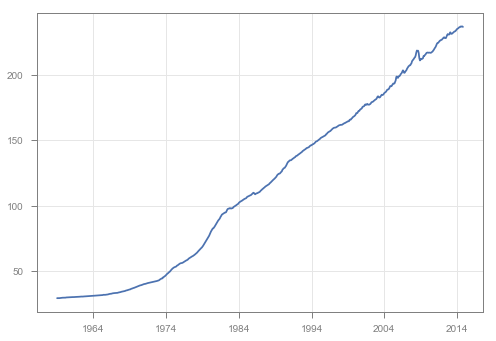

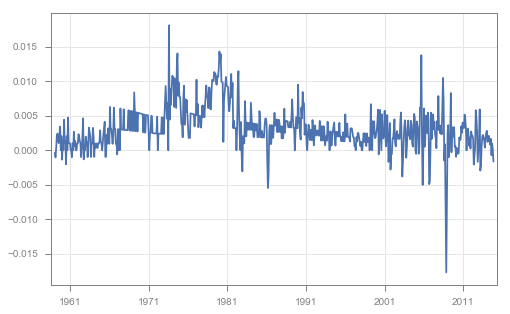

In [147]:
df_raw = data.reset_index(drop = True)
df_raw.columns = ['CPI', 'FF', 'IP', 'emp', 'unemp']

# put the interest variable, CPI, in the format we want to predict: the percentage growth from last period
df = df_raw.copy()

dates = pd.to_datetime(data.index, format='%Y-%m-%d')
plt.plot(dates, df['CPI'])
ax.set_xlim([dates[0] - pd.DateOffset(months=6), dates[-1] + pd.DateOffset(months=6)])
plt.savefig('../../latex/plots/CPI_raw.eps', format='eps', dpi=200)

df['CPI'] = df_raw[['CPI']].pct_change()
df = df.iloc[1:]

fig, ax = plt.subplots(figsize=(8,5))

dates = pd.to_datetime(data.index[1:], format='%Y-%m-%d')
plt.plot(dates, df['CPI'])
ax.set_xlim([dates[0] - pd.DateOffset(months=6), dates[-1] + pd.DateOffset(months=6)])
plt.savefig('../../latex/plots/CPI.eps', format='eps', dpi=200)

In [20]:
import statsmodels.tsa.stattools as tsa

_, pvalue, *_ = tsa.adfuller(df['CPI'])
print("p-value: " + str(pvalue))

p-value: 0.101430948561


Kind of reject the unit root hypothesis => stationary

In [21]:
def splitTimeData(df, ratio):
    rows = len(df.index)
    trainRows = int(rows * (1 - ratio))
    testRows = rows - trainRows
    
    train = df.iloc[0:trainRows-1]
    test = df
    start = trainRows
    
    return train, test, start

df_train, df_test, start = splitTimeData(df, 0.18)

In [29]:
'''
standard transformations
'''
from Transform import Transform as Transform

cols = ['CPI', 'FF', 'IP', 'emp', 'unemp']

t1 = Transform('log', ['IP', 'emp']) # not FF, nor the unemp

o = {
    'diffs': {
        'unemp': 0,
        'IP': 1,
        'emp': 1,
        'FF': 1
    }
}


t2 = Transform('diff', cols, o)
t3 = Transform('standardize', cols)
# t3 = Transform('normalize', cols)

transfs =  [t1, t2, t3]

In [24]:
'''
standard scorefuns
'''

def RMSE(y_hat, y):
    start = y_hat.first_valid_index()
    errors = y.loc[start:] - y_hat
    RMSE = np.sqrt(np.mean(np.square(errors)))[0]
    return RMSE

def MAE(y_hat, y):
    start = y_hat.first_valid_index()
    errors = y.loc[start:] - y_hat
    MAE = np.mean(np.absolute(errors))[0]
    return MAE

In [26]:
TEST_OFFSET = df_train.last_valid_index() + 1
TEST_OFFSET

549

In [27]:
try:
    with open("results.p", "rb" ) as f:
        results = pickle.load(f)
except:
    results = {}
results.keys()

dict_keys([])

# Baseline

In [30]:
from LastPeriod import LastPeriod as LastPeriod

# test
cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 1

def gen_x(X, start):
    X = LastPeriod.gen_X(X, start)
    return X

def gen_y(y, start):
    y = LastPeriod.gen_y(y, start)
    return y

model = LastPeriod()

m = Model(model, transfs, gen_x, gen_y, RMSE)

window =  [1, 4, 12]
ret_base = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'direct')
results['BASE'] = ret_base

[ret_base[h][0] for h in window]

step: 550
step: 560
step: 570
step: 580
step: 590
step: 600
step: 610
step: 620
step: 630
step: 640
step: 650
step: 660
step: 670
step: 550
step: 560
step: 570
step: 580
step: 590
step: 600
step: 610
step: 620
step: 630
step: 640
step: 650
step: 660
step: 670
step: 550
step: 560
step: 570
step: 580
step: 590
step: 600
step: 610
step: 620
step: 630
step: 640
step: 650
step: 660
step: 670


[0.0036895237436290577, 0.0050825064265630207, 0.0054766794523921037]

# Univariate

## AR

In [39]:
from var_model import VAR as VAR

cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 13


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = VAR()

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_AR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['AR'] = ret_AR
[ret_AR[h][0] for h in window]

step: 540
step: 545
step: 550
step: 555
step: 560
step: 565
step: 570
step: 575
step: 580
step: 585
step: 590
step: 595
step: 600
step: 605
step: 610
step: 615
step: 620
step: 625
step: 630
step: 635
step: 640
step: 645
step: 650
step: 655
step: 660
step: 665
step: 670


[0.0033901453821205121, 0.0040276797506789679, 0.0037687363709764761]

## MA

In [40]:
from ARMA import ARMA as ARMA
from var_model import VAR as VAR

# test
cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


lags = 1

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
    X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = ARMA(0, 8)


m = Model(model, transfs, gen_x, gen_y, RMSE)

window =  [1, 4, 12]
ret_MA = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic-ar')
results['MA'] = ret_MA
[ret_MA[h][0] for h in window]

step: 540
step: 545
step: 550
step: 555
step: 560
step: 565
step: 570
step: 575
step: 580
step: 585
step: 590
step: 595
step: 600
step: 605
step: 610
step: 615
step: 620
step: 625
step: 630
step: 635
step: 640
step: 645
step: 650
step: 655
step: 660
step: 665
step: 670


[0.0034222992759186501, 0.0038188570946556828, 0.0038245968340473689]

## ARMA

In [35]:
from ARMA import ARMA as ARMA
from var_model import VAR as VAR

# test
cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


lags = 1

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
    X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = ARMA(4, 1)


m = Model(model, transfs, gen_x, gen_y, RMSE)

window =  [1, 4, 12]
ret_ARMA = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic-ar')
results['ARMA'] = ret_ARMA
[ret_ARMA[h][0] for h in window]

step: 540
step: 545
step: 550
step: 555
step: 560
step: 565
step: 570
step: 575
step: 580
step: 585
step: 590
step: 595
step: 600
step: 605
step: 610
step: 615
step: 620
step: 625
step: 630
step: 635
step: 640
step: 645
step: 650
step: 655
step: 660
step: 665
step: 670


[0.0033515275591373714, 0.0038422510994586558, 0.0037713821117202387]

## MSAR

In [41]:
from MSReg import MSReg

cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MSReg(2)

m = Model(model, transfs, gen_x, gen_y, RMSE)


window = [1, 4, 12]
ret_MSAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic-ar')
results['MSAR'] = ret_MSAR
[ret_MSAR[h][0] for h in window]

step: 540
step: 545
step: 550
step: 555
step: 560
step: 565
step: 570
step: 575
step: 580
step: 585
step: 590
step: 595
step: 600
step: 605
step: 610
step: 615
step: 620
step: 625
step: 630
step: 635
step: 640
step: 645
step: 650
step: 655
step: 660
step: 665
step: 670


[0.0034262320807235914, 0.004117571819408682, 0.0040428343892890718]

## SPLITAR

In [137]:
from splitVAR import splitVAR as splitVAR

cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = splitVAR(2, proba = True, WLS = True, lags = lags, variables = cols, pred_vars = cols, reg_vars = cols)


m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_splitAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['SPLITAR'] = ret_splitAR
[ret_splitAR[h][0] for h in window]

step: 540
step: 545
step: 550
step: 555
step: 560
step: 565
step: 570
step: 575
step: 580
step: 585
step: 590
step: 595
step: 600
step: 605
step: 610
step: 615
step: 620
step: 625
step: 630
step: 635
step: 640
step: 645
step: 650
step: 655
step: 660
step: 665
step: 670


[0.0034198860038889829, 0.0039000259335836948, 0.0038068463393662751]

## MLPAR

In [ ]:
from MLP import MLP

cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 13


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MLP((4,), training_epochs = 5000, beta=0.5, debug = False)

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_MLPAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['MLPAR'] = ret_MLPAR
[ret_MLPAR[h][0] for h in window]

In [62]:
# get it from the file
with open("MLPAR.p", "rb" ) as f:
    ret_MLPAR = pickle.load(f)
    results['MLPAR'] = ret_MLPAR
[ret_MLPAR[h][0] for h in window]

[0.0032664101421922354, 0.0039481231790977596, 0.0037361716878747376]

# Multivariate

## VAR

In [47]:
from var_model import VAR as VAR

cols = ['CPI', 'unemp']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = VAR()

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_VAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['VAR'] = ret_VAR
[ret_VAR[h][0] for h in window]

step: 540
step: 545
step: 550
step: 555
step: 560
step: 565
step: 570
step: 575
step: 580
step: 585
step: 590
step: 595
step: 600
step: 605
step: 610
step: 615
step: 620
step: 625
step: 630
step: 635
step: 640
step: 645
step: 650
step: 655
step: 660
step: 665
step: 670


[0.0034182109242037813, 0.0040359319518390169, 0.0039104013996406825]

## MSVAR

In [78]:
from var_model import VAR as VAR

cols = ['CPI', 'unemp']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MSReg(2)

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_MSVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic-ar')
results['MSVAR'] = ret_MSVAR
[ret_MSVAR[h][0] for h in window]

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:391: RuntimeWarning: invalid value encountered in true_divide
  predicted_joint_probabilities[..., t+1])


step: 540
step: 545
step: 550
step: 555
step: 560


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 565
step: 570
step: 575
step: 580
step: 585
step: 590
step: 595


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 600


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 605


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 610


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 615


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 620


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 625


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 630


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 635


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 640


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 645


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 650


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 655


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

step: 660


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 665
step: 670


[0.0034868687770182602, 0.0039660919816378124, 0.0039072271275987069]

## SPLITVAR

In [136]:
from var_model import VAR as VAR

cols = ['CPI', 'unemp']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = splitVAR(2, proba = True, WLS = True, lags = lags, variables = cols, pred_vars = cols, reg_vars = cols)

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_SPLITVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['SPLITVAR'] = ret_SPLITVAR
[ret_SPLITVAR[h][0] for h in window]

step: 540
step: 545
step: 550
step: 555
step: 560
step: 565
step: 570
step: 575
step: 580
step: 585
step: 590
step: 595
step: 600
step: 605
step: 610
step: 615
step: 620
step: 625
step: 630
step: 635
step: 640
step: 645
step: 650
step: 655
step: 660
step: 665
step: 670


[0.0033992424470741475, 0.0039327821341028461, 0.0038585427484197415]

## MLPVAR

In [ ]:
from MLP import MLP

cols = ['CPI', 'unemp']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MLP((4,), training_epochs = 5000, beta=0.5, debug = True)

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_MLPVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['MLPVAR'] = ret_MLPVAR
[ret_MLPVAR[h][0] for h in window]

In [68]:
# get it from the file
with open("MLPVAR.p", "rb" ) as f:
    ret_MLPVAR = pickle.load(f)
    results['MLPVAR'] = ret_MLPVAR
    
[ret_MLPVAR[h][0] for h in window]

[0.0034263467387137276, 0.0039550720673171731, 0.003864825296878204]

# Factors

## FAVAR

In [52]:
import FAVAR
reload(FAVAR)
FAVAR = 1
from FAVAR import FAVAR

import Model
reload(Model)
Model = 1
from Model import Model


favar = FAVAR(factors_q)
cols = ['CPI']
y_col = ['CPI']


X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)


lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
    X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = VAR()

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_FAVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['FAVAR'] = ret_FAVAR
[ret_FAVAR[h][0] for h in window]

step: 540
step: 545
step: 550
step: 555
step: 560
step: 565
step: 570
step: 575
step: 580
step: 585
step: 590
step: 595
step: 600
step: 605
step: 610
step: 615
step: 620
step: 625
step: 630
step: 635
step: 640
step: 645
step: 650
step: 655
step: 660
step: 665
step: 670


[0.0034251271747871796, 0.0040777985876607565, 0.0039193545789352538]

## MSFAVAR

In [79]:
cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)

lags = 4

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MSReg(2)
m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_MSFAVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic-ar')
results['MSFAVAR'] = ret_MSFAVAR
[ret_MSFAVAR[h][0] for h in window]

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:391: RuntimeWarning: invalid value encountered in true_divide
  predicted_joint_probabilities[..., t+1])


step: 540
step: 545
step: 550
step: 555
step: 560
step: 565
step: 570
step: 575
step: 580
step: 585
step: 590
step: 595


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 600


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 605
step: 610
step: 615
step: 620
step: 625
step: 630
step: 635
step: 640
step: 645
step: 650
step: 655
step: 660
step: 665
step: 670


[0.0035458141364374642, 0.004000657932079617, 0.0038703462388519298]

## SPLITFAVAR

In [135]:
import splitVAR
reload(splitVAR)
splitVAR = 1
from splitVAR import splitVAR

cols = ['CPI']
y_col = ['CPI']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)

lags = 4

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = splitVAR(2, proba = True, WLS = True, lags = lags, variables = cols, pred_vars = cols, reg_vars = cols)
m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_SPLITFAVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['SPLITFAVAR'] = ret_SPLITFAVAR
[ret_SPLITFAVAR[h][0] for h in window]

step: 540
step: 545
step: 550
step: 555
step: 560
step: 565
step: 570
step: 575
step: 580
step: 585
step: 590
step: 595
step: 600
step: 605
step: 610
step: 615
step: 620
step: 625
step: 630
step: 635
step: 640
step: 645
step: 650
step: 655
step: 660
step: 665
step: 670


[0.0033947691141423771, 0.0039750629296103806, 0.0037980588889101673]

## MLPFAVAR

In [ ]:
favar = FAVAR(factors_q)

cols = ['CPI']
y_col = ['CPI']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)

lags = 4

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MLP((4,), training_epochs = 5000, beta=0.5, debug = False)
m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_MLPFAVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['MLPFAVAR'] = ret_MLPFAVAR
[ret_MLPFAVAR[h][0] for h in window]

In [63]:
# get it from the file
with open("MLPFAVAR.p", "rb" ) as f:
    ret_MLPFAVAR = pickle.load(f)
    results['MLPFAVAR'] = ret_MLPFAVAR
[ret_MLPFAVAR[h][0] for h in window]

[0.0033652172312903443, 0.0039088851954676247, 0.003802272265548687]

# Results

In [139]:
def SE(pred, real):
    return (pred - real)*(pred - real)

def AE(pred, real):
    return abs(pred - real)
    
def DM(results, y, loss, cols = None):
    if cols is None:
        cols = list(results.keys())
    
    ret = {}
    for h in [1, 4, 12]:
        ret[h] = pd.DataFrame(columns=cols[1:], index=cols[0:-1])
        for i in range(len(cols)-1):
            row = {}
            col1 = cols[i]
            for j in range(i+1, len(cols)):
                col2 = cols[j]
                pred1 = results[col1][h][1]
                pred2 = results[col2][h][1]
                row[col2] = DM_comparison(pred2, pred1, y, loss, h)
            ret[h].loc[col1] = pd.Series(row)
            
            
    return ret

def DM_comparison(pred1, pred2, real, loss, h):
    first = pred1.first_valid_index()
    # remove the y values that were used for training
    real = real.loc[first:]
    
    # apply the loss function to every element 
    def f(row):
        return loss(row.iloc[0], row.iloc[1])

    loss1 = pd.concat([pred1, real], axis=1).apply(f, axis=1)
    loss2 = pd.concat([pred2, real], axis=1).apply(f, axis=1)
    d = loss1 - loss2
    d = d.reset_index(drop=True)
#     print(d)
    T = len(d)
    Z = np.mean(d) / np.sqrt(NW(d, h)/T)
#     return NW(d, h)
    return Z

def autocov(d, tau):
    T = len(d)
    mu = np.mean(d)
    return np.mean([(d[i] - mu)*(d[i-tau] - mu) for i in range(tau, T)])
    
def NW(d, h):
    q = h-1
    V = autocov(d, 0) + 2*np.sum([(1 - (nu)/(q+1)) * autocov(d, nu) for nu in range(1, q)])
    return V
    


ret_DM = DM(results, y_test, SE)#, ['FAVAR', 'MSFAVAR', 'ARMA'])

print(ret_DM[1])
print(ret_DM[4])
ret_DM[12]

                  AR        MA      ARMA       MSAR    SPLITAR     MLPAR  \
BASE       -0.795284 -0.850471 -0.893693  -0.788931  -0.745596  -1.29412   
AR               NaN  0.208891 -0.330883   0.242458   0.200584 -0.973376   
MA               NaN       NaN -0.664799  0.0392327 -0.0212928 -0.934217   
ARMA             NaN       NaN       NaN   0.847808   0.902903 -0.525112   
MSAR             NaN       NaN       NaN        NaN  -0.116567  -1.03792   
SPLITAR          NaN       NaN       NaN        NaN        NaN -0.966541   
MLPAR            NaN       NaN       NaN        NaN        NaN       NaN   
VAR              NaN       NaN       NaN        NaN        NaN       NaN   
MSVAR            NaN       NaN       NaN        NaN        NaN       NaN   
SPLITVAR         NaN       NaN       NaN        NaN        NaN       NaN   
MLPVAR           NaN       NaN       NaN        NaN        NaN       NaN   
FAVAR            NaN       NaN       NaN        NaN        NaN       NaN   
MSFAVAR     

,AR,MA,ARMA,MSAR,SPLITAR,MLPAR,VAR,MSVAR,SPLITVAR,MLPVAR,FAVAR,MSFAVAR,SPLITFAVAR,MLPFAVAR
BASE,-2.77775,-2.71293,-2.82259,-2.11153,-2.79163,-2.85639,-2.57826,-2.60281,-2.73657,-2.66788,-2.60602,-2.66488,-2.82223,-2.78398
AR,NaN,0.594442,0.0391697,0.633617,0.294941,-0.533995,1.73459,1.52151,0.652159,1.0922,2.18447,1.53408,0.155315,0.264485
MA,NaN,NaN,-0.498852,0.559329,-0.138998,-0.936356,2.11301,1.13145,0.279779,0.489536,1.13873,0.603761,-0.132125,-0.166505
ARMA,NaN,NaN,NaN,0.662606,0.418878,-0.459631,1.67989,1.71156,0.852058,1.46799,2.38891,1.66644,0.182437,0.390504
MSAR,NaN,NaN,NaN,NaN,-0.603128,-0.763317,-0.3468,-0.351115,-0.508792,-0.461895,-0.29721,-0.421144,-0.591742,-0.621686
SPLITAR,NaN,NaN,NaN,NaN,NaN,-0.506242,1.07576,1.47778,0.779913,0.979097,1.31367,0.743314,-0.10311,-0.0855115
MLPAR,NaN,NaN,NaN,NaN,NaN,NaN,1.97458,1.56649,0.961682,1.30107,1.83569,1.4821,0.298023,0.504712
VAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0782944,-0.569102,-0.952365,0.148813,-0.785692,-0.666808,-1.06006
MSVAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.588451,-1.43458,0.236956,-0.791642,-0.82105,-1.297
SPLITVAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0858786,0.555383,0.115138,-0.463405,-0.778393


In [138]:
pickle.dump(results, open( "results.p", "wb" ) )

In [140]:
import io
import math


def process_val(val):
    if math.isnan(val):
        return '-'
    else:
        if abs(val) > 1.96:
            return '\\textbf{ ' + '{:.2f}'.format(round(val, 2)) + '}'
        else:
            return '{:.2f}'.format(round(val, 2))

                                   
def convertToLaTeX(df, alignment="c", title=''):
    """
    Convert a pandas dataframe to a LaTeX tabular.
    Prints labels in bold, does not use math mode
    """
    numColumns = df.shape[1]
    numRows = df.shape[0]
    output = io.StringIO()
    colFormat = ("%s|%s" % ('r', alignment * numColumns))
    #Write header
    output.write("\\begin{tabular}{%s}\n" % colFormat)
    columnLabels = ["\\rot{ \\textbf{%s} }" % label for label in df.columns]
    output.write("%s& %s\\\\\\hline\n" % (title, " & ".join(columnLabels)))
    #Write data lines
    for i in range(numRows):
        output.write("\\textbf{%s} & %s\\\\\n"
                     % (df.index[i], " & ".join([process_val(val) for val in df.iloc[i]])))
    #Write footer
    output.write("\\end{tabular}")
    return output.getvalue()

out = 'CPI'
for h in [1, 4, 12]:
    with open('../../latex/tabs/DM_' + out + '_' + str(h) + '.tex', "w" ) as f:
        f.write(convertToLaTeX(ret_DM[h], title=out + ': ' + str(h) + ' ahead'))

In [141]:
def cost_comparison(results, y, losses, losses_names, models=None):
    if models is None:
        models = list(results.keys())
        
    hs = results[models[0]].keys()

    tuples = [(loss, h) for loss in losses_names for h in hs]
    index = pd.MultiIndex.from_tuples(tuples, names=['Loss', 'Periods ahead'])
    ret = pd.DataFrame(columns = index)
#     ret.loc['base'] = pd.Series(np.random.randn(6), index=index)
    for model in models:
        s = pd.Series(index=index)
        for loss_idx in range(len(losses)):
            for h in hs:
                loss = losses[loss_idx]
                s.loc[(losses_names[loss_idx], h)] = loss(results[model][h][1], y)                
        ret.loc[model] = s
        
    
    return ret
    

def scale_losses(ret_losses):
    losses = list(ret_losses.columns.get_level_values(0).unique())
    hs = list(ret_losses.columns.get_level_values(1).unique())
    
    for loss in losses:
        ref = ret_losses[loss][hs[0]].iloc[0]
        ret_losses[loss] = ret_losses[loss] / ref
    
    return ret_losses
    
def is_col_min(df):
    return df == df.min()
    
ret_losses_r = cost_comparison(results, y_test, [RMSE, MAE], ['RMSE', 'MAE'])

# scale the results so that the 1 period loss is always 1

ret_losses = scale_losses(ret_losses_r.copy())

ret_losses_is_min = is_col_min(ret_losses)

pickle.dump(ret_losses, open( "../agg/CPI.p", "wb" ) )

ret_losses

Loss               RMSE                           MAE                    
Periods ahead        1         4         12        1         4         12
BASE           1.000000  1.377551  1.484387  1.000000  1.302951  1.488913
AR             0.918857  1.091653  1.021470  0.858323  1.022584  0.952531
MA             0.927572  1.035054  1.036610  0.874194  1.008575  1.012870
ARMA           0.908390  1.041395  1.022187  0.837603  0.936154  0.949173
MSAR           0.928638  1.116017  1.095761  0.840958  1.107058  1.097140
SPLITAR        0.926918  1.057054  1.031799  0.846705  0.922754  0.966589
MLPAR          0.885320  1.070090  1.012643  0.835921  0.967465  0.963098
VAR            0.926464  1.093890  1.059866  0.857562  1.026813  1.038511
MSVAR          0.945073  1.074960  1.059006  0.861138  1.003154  1.024839
SPLITVAR       0.921323  1.065932  1.045811  0.857115  0.965617  1.014866
MLPVAR         0.928669  1.071974  1.047513  0.852069  0.978946  0.997208
FAVAR          0.928339  1.105237  1.062293  0.862299  1.013330  1.020517
MSFAVAR        0.961049  1.084329  1.049010  0.863897  0.977454  1.000428
SPLITFAVAR     0.920110  1.077392  1.029417  0.845805  0.926225  0.948944
MLPFAVAR       0.912101  1.059455  1.030559  0.850905  0.924221  0.983994

In [142]:
from itertools import groupby

def process_val(val, i, j):
    if ret_losses_is_min.iloc[i, j]: # is col min
        return '{\\color{red} \\textbf{' + str(round(val, 2)) + '}}'
    else:
        return str(round(val, 2))

def convertToLaTeX(df, alignment="c"):
    """
    Convert a pandas dataframe to a LaTeX tabular.
    Prints labels in bold, does not use math mode
    """
    first = list(df.columns.get_level_values(0))
    first_group = [(key, len(list(group))) for key, group in groupby(first)]
    second = list(df.columns.get_level_values(1))
    
    numColumns = df.shape[1]
    numRows = df.shape[0]
    output = io.StringIO()
    cols_align = "|".join(["%s" % (alignment * l) for key, l in first_group])
    colFormat = ("%s|%s" % ('l', cols_align))
    #Write header
    output.write("\\begin{tabular}{%s}\n" % colFormat)
    output.write('\\toprule\n')
        
    # top cols    
    columnLabels = ["\multicolumn{%i}{c}{%s}" % (l, label) for label, l in first_group]
    output.write("%s & %s\\\\\n" % (df.columns.names[0]," & ".join(columnLabels)))
    
    # second col
    columnLabels = ["%s" % label for label in second]
    output.write("%s & %s\\\\\\hline\n" % (df.columns.names[1]," & ".join(columnLabels)))

#     columnLabels = ["\\rot{ \\textbf{%s} }" % label for label in df.columns]
#     output.write("& %s\\\\\\hline\n" % " & ".join(columnLabels))
    #Write data lines
    for i in range(numRows):
        output.write("%s & %s\\\\\n"
                     % (df.index[i], " & ".join([process_val(df.iloc[i, j], i, j) for j in range(numColumns)])))
    #Write footer
    output.write("\\end{tabular}")
    return output.getvalue()

with open('../../latex/tabs/CPI_losses.tex', "w" ) as f:
    f.write(convertToLaTeX(ret_losses))

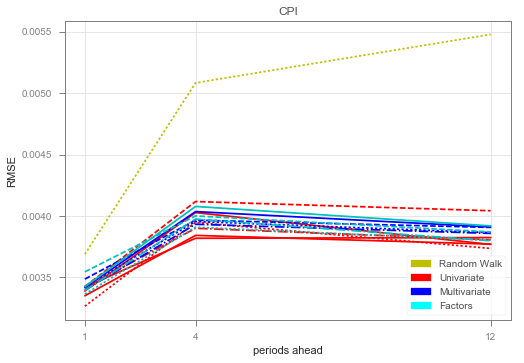

In [148]:
import matplotlib.patches as mpatches


df = ret_losses_r['RMSE'].transpose()

plt.plot(df['BASE'], color='y', linestyle = ':')
plt.plot(df['AR'], color='r')
plt.plot(df['MA'], color='r')
plt.plot(df['ARMA'], color='r', linestyle = '-')
plt.plot(df['MSAR'], color='r', linestyle = '--')
plt.plot(df['SPLITAR'], color='r', linestyle = '-.')
plt.plot(df['MLPAR'], color='r', linestyle = ':')
plt.plot(df['VAR'], color='b', linestyle = '-')
plt.plot(df['MSVAR'], color='b', linestyle = '--')
plt.plot(df['SPLITVAR'], color='b', linestyle = '-.')
plt.plot(df['MLPVAR'], color='b', linestyle = ':')
plt.plot(df['FAVAR'], color='c', linestyle = '-')
plt.plot(df['MSFAVAR'], color='c', linestyle = '--')
plt.plot(df['SPLITFAVAR'], color='c', linestyle = '-.')
plt.plot(df['MLPFAVAR'], color='c', linestyle = ':')

plt.xticks([1, 4, 12])
plt.xlabel('periods ahead')
plt.ylabel('RMSE')

RW = mpatches.Patch(color='y', label='Random Walk')
uni = mpatches.Patch(color='red', label='Univariate')
multi = mpatches.Patch(color='blue', label='Multivariate')
factors = mpatches.Patch(color='cyan', label='Factors')



plt.legend(handles=[RW, uni, multi, factors], loc='lower right', frameon=True)


plt.title('CPI')
plt.savefig('../../latex/plots/CPI_all.eps', format='eps', dpi=200)

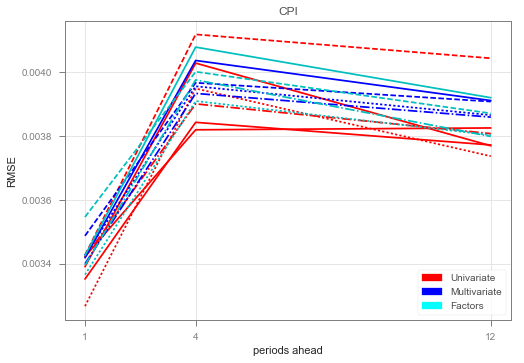

In [149]:
import matplotlib.patches as mpatches


df = ret_losses_r['RMSE'].transpose()

plt.plot(df['AR'], color='r')
plt.plot(df['MA'], color='r')
plt.plot(df['ARMA'], color='r', linestyle = '-')
plt.plot(df['MSAR'], color='r', linestyle = '--')
plt.plot(df['SPLITAR'], color='r', linestyle = '-.')
plt.plot(df['MLPAR'], color='r', linestyle = ':')
plt.plot(df['VAR'], color='b', linestyle = '-')
plt.plot(df['MSVAR'], color='b', linestyle = '--')
plt.plot(df['SPLITVAR'], color='b', linestyle = '-.')
plt.plot(df['MLPVAR'], color='b', linestyle = ':')
plt.plot(df['FAVAR'], color='c', linestyle = '-')
plt.plot(df['MSFAVAR'], color='c', linestyle = '--')
plt.plot(df['SPLITFAVAR'], color='c', linestyle = '-.')
plt.plot(df['MLPFAVAR'], color='c', linestyle = ':')

plt.xticks([1, 4, 12])
plt.xlabel('periods ahead')
plt.ylabel('RMSE')

uni = mpatches.Patch(color='red', label='Univariate')
multi = mpatches.Patch(color='blue', label='Multivariate')
factors = mpatches.Patch(color='cyan', label='Factors')



plt.legend(handles=[uni, multi, factors], loc='lower right', frameon=True)


plt.title('CPI')
plt.savefig('../../latex/plots/CPI_all_zoomed.eps', format='eps', dpi=200)

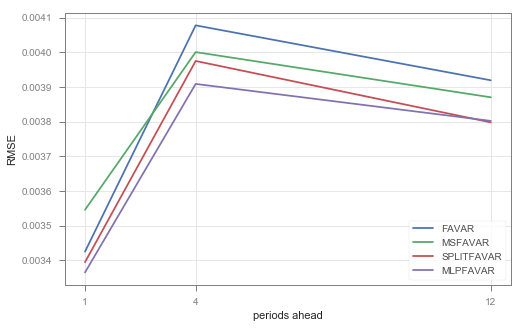

In [145]:
fig, ax = plt.subplots(figsize=(8,5))


plt.plot(df['FAVAR'], label='FAVAR')
plt.plot(df['MSFAVAR'], label='MSFAVAR')
plt.plot(df['SPLITFAVAR'], label='SPLITFAVAR')
plt.plot(df['MLPFAVAR'], label='MLPFAVAR')

plt.xticks([1, 4, 12])
plt.xlabel('periods ahead')
plt.ylabel('RMSE')

legend = ax.legend(loc='lower right', frameon=True)

plt.savefig('../../latex/plots/CPI_favar.eps', format='eps', dpi=200)